In [1]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O cats_and_dogs_filtered.zip

--2021-08-09 22:05:00--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   202MB/s    in 0.3s    

2021-08-09 22:05:01 (202 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
! unzip -q cats_and_dogs_filtered.zip

In [3]:
train_dir = "cats_and_dogs_filtered/train"
validation_dir = "cats_and_dogs_filtered/validation"

## Primero como siempre importamos los datos

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Ahora importamos la red y los pesos de la red VGG16

In [5]:
from tensorflow.keras.applications import VGG16

vgg_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [6]:
vgg_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Setear los parámetros del modelo base a no entrenable

In [7]:
vgg_base.trainable=False 

### Ahora hay que agregar las últimas capas de la red:

In [9]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(vgg_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

### Entrenamos el modelo

In [10]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [11]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=3,
      validation_data=validation_generator,
      validation_steps=50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
100/100 [==============================] - 50s 186ms/step - loss: 0.6060 - acc: 0.6660 - val_loss: 0.4450 - val_acc: 0.8240
Epoch 2/3
100/100 [==============================] - 18s 184ms/step - loss: 0.4638 - acc: 0.7940 - val_loss: 0.3687 - val_acc: 0.8410
Epoch 3/3
100/100 [==============================] - 20s 196ms/step - loss: 0.4293 - acc: 0.8145 - val_loss: 0.3296 - val_acc: 0.8630


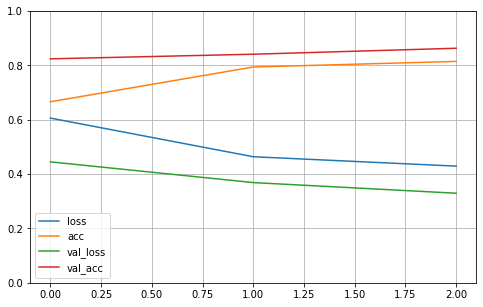

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# TAREA: Hacer lo mismo con ResNet50:

In [29]:
from tensorflow.keras.applications import ResNet50

base_resnet = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(150, 150, 3)
)

In [ ]:
base_resnet.summary()

In [31]:
base_resnet.trainable=False 

In [32]:
model2 = models.Sequential()
model2.add(base_resnet)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_4 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 36,695,425
Trainable params: 13,107,713
Non-trainable params: 23,587,712
_________________________________________________________________


In [38]:
model2.compile(loss='binary_crossentropy', optimizer=optimizers.Adamax(learning_rate=1e-5), metrics=['acc'])

history2 = model2.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 [==============================] - 23s 207ms/step - loss: 0.6671 - acc: 0.6005 - val_loss: 0.6538 - val_acc: 0.6190
Epoch 2/100
100/100 [==============================] - 20s 197ms/step - loss: 0.6660 - acc: 0.5895 - val_loss: 0.6517 - val_acc: 0.6150
Epoch 3/100
100/100 [==============================] - 19s 194ms/step - loss: 0.6651 - acc: 0.6035 - val_loss: 0.6499 - val_acc: 0.6200
Epoch 4/100
100/100 [==============================] - 19s 185ms/step - loss: 0.6645 - acc: 0.6070 - val_loss: 0.6490 - val_acc: 0.6210
Epoch 5/100
100/100 [==============================] - 19s 190ms/step - loss: 0.6619 - acc: 0.6100 - val_loss: 0.6488 - val_acc: 0.6120
Epoch 6/100
100/100 [==============================] - 20s 198ms/step - loss: 0.6584 - acc: 0.6125 - val_loss: 0.6526 - val_acc: 0.6170
Epoch 7/100
100/100 [==============================] - 19s 186ms/step - loss: 0.6618 - acc: 0.6020 - val_loss: 0.6487 - val_acc: 0.6120
Epoch 8/100
100/100 [===========================

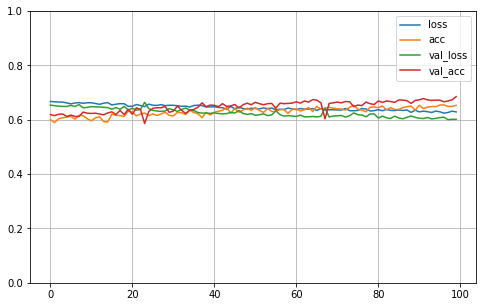

In [39]:
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()